<a href="https://colab.research.google.com/github/DevilNReality/Customer-Segmentation/blob/main/Code%20File/Customer%20Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset And Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans , AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from scipy.cluster.hierarchy import linkage , dendrogram
import warnings
warnings.simplefilter(action = 'ignore')

In [2]:
df = pd.read_excel('/content/Online Retail.xlsx')

# Data Preparation

In [3]:
df.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
10618,537237,22788,BROCANTE COAT RACK,1,2010-12-06 09:58:00,20.38,NaN,United Kingdom
507826,579187,23399,HOME SWEET HOME HANGING HEART,4,2011-11-28 15:31:00,2.08,NaN,United Kingdom
355597,567954,23445,ICE CREAM BUBBLES,20,2011-09-23 08:30:00,0.83,13004.0,United Kingdom
143572,548708,22972,CHILDREN'S SPACEBOY MUG,6,2011-04-03 12:41:00,1.65,13269.0,United Kingdom
334519,566258,22835,HOT WATER BOTTLE I AM SO POORLY,1,2011-09-11 12:45:00,4.95,13124.0,United Kingdom
145188,548870,21889,WOODEN BOX OF DOMINOES,1,2011-04-04 14:41:00,1.25,14606.0,United Kingdom
53017,540821,17012B,ORIGAMI JASMINE INCENSE/CANDLE SET,2,2011-01-11 13:16:00,2.51,NaN,United Kingdom
327969,565738,22350,ILLUSTRATED CAT BOWL,6,2011-09-06 12:30:00,2.55,14667.0,United Kingdom
41292,539825,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-22 12:22:00,4.95,NaN,United Kingdom
448565,575063,21754,HOME BUILDING BLOCK WORD,1,2011-11-08 12:32:00,6.25,16764.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
# drop rows with any missing values
df.dropna(inplace=True)

In [7]:
# recheck
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


# K-Means Clustering

In [8]:
# RFM feature engineering
# get the total price of each order
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# create customer df and features
customer_df = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (df['InvoiceDate'].max() - x.max()).days,
                                            'InvoiceNo': 'count',
                                            'TotalPrice': 'sum'})

# rename the features
customer_df.rename(columns={'InvoiceDate': 'recency',
                            'InvoiceNo': 'frequency',
                            'TotalPrice': 'monetary'}, inplace=True)

customer_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4372 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   recency    4372 non-null   int64  
 1   frequency  4372 non-null   int64  
 2   monetary   4372 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 136.6 KB


In [9]:
customer_df.sample(10)

,recency,frequency,monetary
CustomerID,,,
15599.0,26,52,761.74
16282.0,339,11,168.30
16475.0,87,28,544.30
12509.0,283,7,176.50
13453.0,165,17,356.98
15838.0,10,169,33350.76
14167.0,38,52,574.84
14001.0,45,40,2030.33
17483.0,64,21,414.04


In [10]:
customer_df.describe()

,recency,frequency,monetary
count,4372.000000,4372.000000,4372.000000
mean,91.047118,93.053294,1898.459701
std,100.765435,232.471608,8219.345141
min,0.000000,1.000000,-4287.630000
25%,16.000000,17.000000,293.362500
50%,49.000000,42.000000,648.075000
75%,142.000000,102.000000,1611.725000
max,373.000000,7983.000000,279489.020000


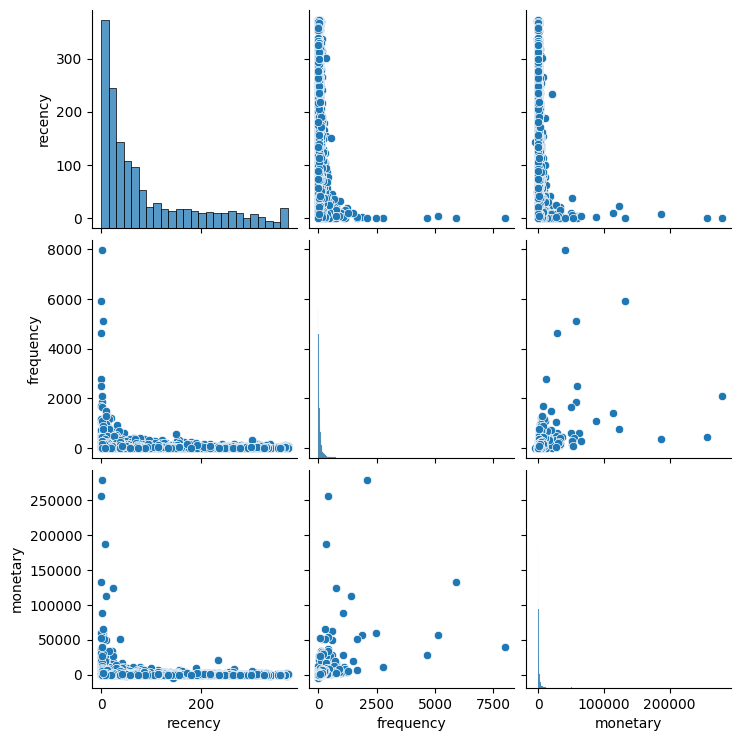

In [11]:
sns.pairplot(customer_df)

In [12]:
# We choose to use minmaxscaler because we are mostly looking to normalize the data and not looking for a mean equal to zero.
scaler = MinMaxScaler()

norm_customer = scaler.fit_transform(customer_df)

print(norm_customer)

[[8.71313673e-01 1.25281884e-04 1.51091712e-02]
 [2.68096515e-03 2.26760210e-02 3.02971721e-02]
 [1.98391421e-01 3.75845653e-03 2.14424619e-02]
 ...
 [1.87667560e-02 1.50338261e-03 1.57314917e-02]
 [8.04289544e-03 9.45878226e-02 2.24913149e-02]
 [1.12600536e-01 8.64445001e-03 2.15835588e-02]]


In [13]:
# fit model with different num of clsuters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=33)
    kmeans.fit(norm_customer)
    sse.append(kmeans.inertia_) # sse of the centroid of cluster

Text(0, 0.5, 'sse')

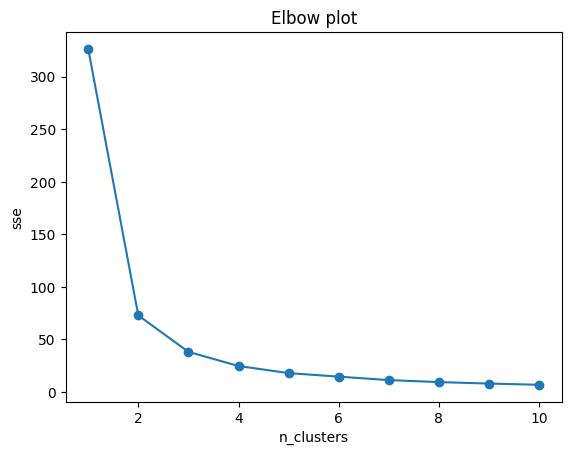

In [14]:
# create sse elbow plot
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow plot')
plt.xlabel('n_clusters')
plt.ylabel('sse')

In [15]:
# create the final kmeans model
fin_kmeans = KMeans(n_clusters=4, n_init=10, random_state=33)

fin_kmeans.fit(norm_customer)

KMeans(n_clusters=4, n_init=10, random_state=33)

In [16]:
fin_df = pd.DataFrame(norm_customer, columns=customer_df.columns, index=customer_df.index)

fin_df['cluster'] = fin_kmeans.labels_
fin_df

,recency,frequency,monetary,cluster
CustomerID,,,,
12346.0,0.871314,0.000125,0.015109,2
12347.0,0.002681,0.022676,0.030297,0
12348.0,0.198391,0.003758,0.021442,3
12349.0,0.048257,0.009020,0.021303,0
12350.0,0.828418,0.002005,0.016288,2
...,...,...,...,...
18280.0,0.742627,0.001128,0.015746,2
18281.0,0.482574,0.000752,0.015394,1
18282.0,0.018767,0.001503,0.015731,0


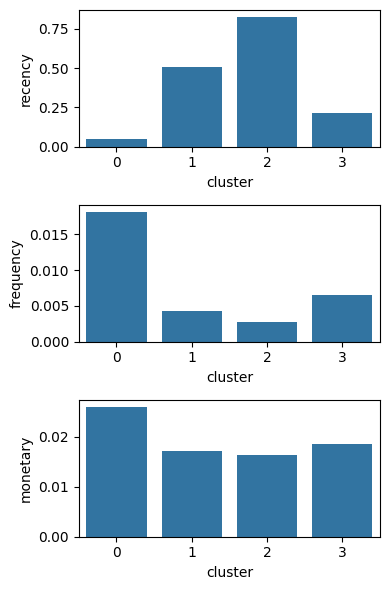

In [17]:
cluster_mean = fin_df.groupby('cluster')[['recency', 'frequency', 'monetary']].mean().reset_index()

fig, axes = plt.subplots(nrows=3, figsize=(4, 6))

sns.barplot(cluster_mean, x='cluster', y='recency', ax=axes[0])
sns.barplot(cluster_mean, x='cluster', y='frequency', ax=axes[1])
sns.barplot(cluster_mean, x='cluster', y='monetary', ax=axes[2])

plt.tight_layout()

In [18]:
fin_df['cluster'].value_counts()

cluster
0    2166
3    1073
1     627
2     506
Name: count, dtype: int64

# Hierarchical Clustering

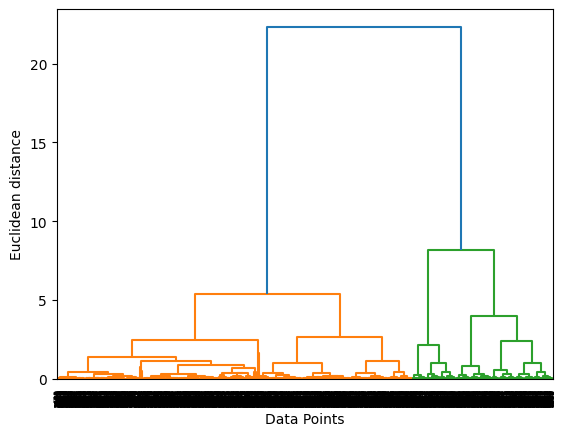

In [19]:
merging = linkage(norm_customer, method='ward')
dendrogram(merging, leaf_rotation=90)
plt.xlabel('Data Points')
plt.ylabel('Euclidean distance')
plt.show()

In [20]:
hc = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
cluster_hc = hc.fit_predict(norm_customer)

In [21]:
with_hc_df = pd.DataFrame(norm_customer, columns=customer_df.columns, index=customer_df.index)
with_hc_df['cluster'] = cluster_hc
with_hc_df.head()

,recency,frequency,monetary,cluster
CustomerID,,,,
12346.0,0.871314,0.000125,0.015109,2
12347.0,0.002681,0.022676,0.030297,0
12348.0,0.198391,0.003758,0.021442,0
12349.0,0.048257,0.009020,0.021303,0
12350.0,0.828418,0.002005,0.016288,2


In [22]:
with_hc_df['cluster'].value_counts(ascending=True)

cluster
2     391
1     850
0    3131
Name: count, dtype: int64

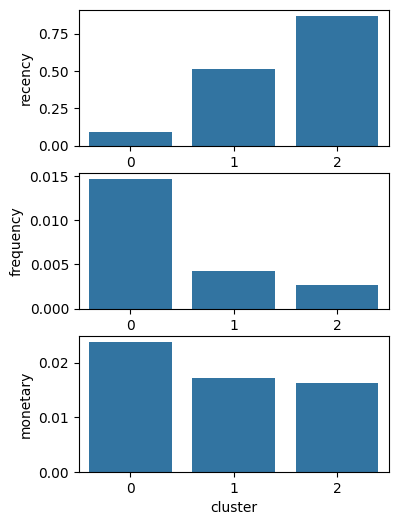

In [23]:
cluster_mean = with_hc_df.groupby('cluster')[['recency', 'frequency', 'monetary']].mean().reset_index()

fig, axes = plt.subplots(nrows=3, figsize=(4, 6))

sns.barplot(cluster_mean, x='cluster', y='recency', ax=axes[0])
sns.barplot(cluster_mean, x='cluster', y='frequency', ax=axes[1])
sns.barplot(cluster_mean, x='cluster', y='monetary', ax=axes[2])

plt.show()